In [2]:
import os
from dotenv import load_dotenv
from langchain_groq import ChatGroq
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_ollama import ChatOllama
from typing import TypedDict, Literal
from pydantic import BaseModel, Field
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import HumanMessage, SystemMessage

# Load environment variables
load_dotenv()

# 1. The Router (Groq Llama 3.3) - Ultra fast classification
groq = ChatGroq(
    model="llama-3.3-70b-versatile", 
    api_key=os.getenv("GROQ_API_KEY")
)

# 2. The Tech Specialist (Google Gemini 2.0 Flash) - High intelligence
gemini = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash", 
    google_api_key=os.getenv("GOOGLE_API_KEY")
)

# 3. The Generalist (Ollama Local) - Secure and private
ollama = ChatOllama(
    model="qwen3:8b", 
    base_url="http://localhost:11434"
)

In [4]:
class QuadState(TypedDict):

    a:int
    b:int
    c:int 

    equation:str 
    discriminant:float
    result:str 
    explanation: str
    

In [5]:
graph=StateGraph(QuadState)

In [6]:
def show_equation(state: QuadState):
    equation = f'{state["a"]}x^2 + {state["b"]}x + {state["c"]}'
    return {"equation": equation}


def calculate_discriminant(state: QuadState):
    discriminant = state["b"]**2 - 4 * state["a"] * state["c"]
    return {"discriminant": discriminant}

import math

def real_roots(state: QuadState):
    a, b, d = state["a"], state["b"], state["discriminant"]
    root1 = (-b + math.sqrt(d)) / (2 * a)
    root2 = (-b - math.sqrt(d)) / (2 * a)
    return {"result": f"The roots are {root1} and {root2}"}

def repeated_roots(state: QuadState):
    a, b = state["a"], state["b"]
    root = -b / (2 * a)
    return {"result": f"The only repeating root is {root}"}


def no_real_roots(state:QuadState):
    result=f'no real roots'
    return {"result":result}


        

In [7]:
def check_condition(state: QuadState):
    if state["discriminant"] > 0:
        return "real"
    elif state["discriminant"] == 0:
        return "repeat"
    else:
        return "none"


In [8]:
def groq_explainer(state: QuadState):
    prompt = f"""
You are a math tutor.

Equation: {state["equation"]}
Discriminant: {state["discriminant"]}
Result: {state["result"]}

Explain the solution in simple terms.
"""
    response = groq.invoke(prompt)
    return {"explanation": response.content}

In [9]:
graph = StateGraph(QuadState)


In [10]:
graph.add_node("show_equation", show_equation)
graph.add_node("calculate_discriminant", calculate_discriminant)
graph.add_node("real_roots", real_roots)
graph.add_node("repeated_roots", repeated_roots)
graph.add_node("no_real_roots", no_real_roots)
graph.add_node("groq", groq_explainer)

# edges
graph.add_edge(START, "show_equation")
graph.add_edge("show_equation", "calculate_discriminant")

graph.add_conditional_edges(
    "calculate_discriminant",
    check_condition,
    {
        "real": "real_roots",
        "repeat": "repeated_roots",
        "none": "no_real_roots",
    }
)

graph.add_edge("real_roots", "groq")
graph.add_edge("repeated_roots", "groq")
graph.add_edge("no_real_roots", "groq")

graph.add_edge("groq", END)


In [11]:
workflow=graph.compile()

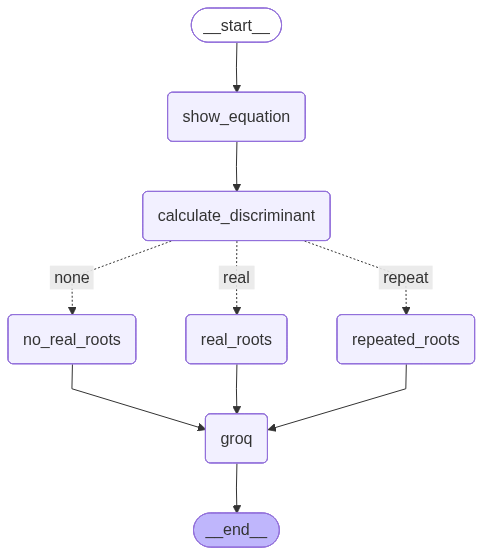

In [12]:
workflow

In [14]:
answer=workflow.invoke({"a":3,"b":43,"c":43})

In [16]:
answer

{'a': 3,
 'b': 43,
 'c': 43,
 'equation': '3x^2 + 43x + 43',
 'discriminant': 1333,
 'result': 'The roots are -1.0816212454904388 and -13.251712087842895',
 'explanation': "Let's break down the solution to the quadratic equation 3x^2 + 43x + 43.\n\nThe discriminant, which is 1333, tells us that the equation has two real roots (solutions). To find these roots, we can use the quadratic formula:\n\nx = (-b ± √(b^2 - 4ac)) / 2a\n\nIn this case, a = 3, b = 43, and c = 43. Plugging these values into the formula, we get:\n\nx = (-(43) ± √((43)^2 - 4(3)(43))) / 2(3)\nx = (-43 ± √(1849 - 516)) / 6\nx = (-43 ± √1333) / 6\n\nSimplifying this, we get two possible values for x:\n\nx = (-43 + √1333) / 6 or x = (-43 - √1333) / 6\n\nUsing a calculator to find the square root of 1333, we get:\n\n√1333 ≈ 36.49\n\nNow, let's plug this value back into our equations:\n\nx = (-43 + 36.49) / 6 or x = (-43 - 36.49) / 6\nx ≈ -6.51 / 6 or x ≈ -79.49 / 6\nx ≈ -1.085 or x ≈ -13.248\n\nThese values are very close 